<a href="https://colab.research.google.com/github/fatemehnasirigheshlagi/portfolio-optimization/blob/main/wax_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas scikit-learn openpyxl matplotlib joblib


In [2]:
import os
import math
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    r2_score, mean_absolute_error, mean_squared_error
)


In [3]:
from google.colab import files
uploaded = files.upload()

# مثلا اگر اسم فایل شما data.xlsx هست:
EXCEL_PATH = "cleendata.xlsx"
SHEET_NAME = 0   # اگر شیت اول باشه


Saving cleendata.xlsx to cleendata.xlsx


In [4]:
# ستون‌های A تا AF → ورودی
# ستون AG → خروجی
df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)

X = df.iloc[:, 0:32].copy()   # ستون‌های A تا AF
y = df.iloc[:, 32].copy()     # ستون AG


In [5]:
def is_classification_series(s: pd.Series) -> bool:
    if s.dtype == 'O':
        return True
    try:
        s_numeric = pd.to_numeric(s, errors='coerce')
        unique_non_nan = pd.Series(s_numeric.dropna().unique())
        if len(unique_non_nan) <= 20 and np.allclose(unique_non_nan, np.round(unique_non_nan)):
            return True
    except Exception:
        return True
    return False

is_classification = is_classification_series(y)
print("Classification?" , is_classification)


Classification? False


In [6]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)


In [7]:
if is_classification:
    from sklearn.tree import DecisionTreeClassifier
    estimator = DecisionTreeClassifier(random_state=42)
    scoring = "accuracy"
else:
    from sklearn.tree import DecisionTreeRegressor
    estimator = DecisionTreeRegressor(random_state=42)
    scoring = "r2"

pipe = Pipeline(steps=[("prep", preprocess), ("model", estimator)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=y if is_classification else None
)

pipe.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['H2S ', 'N2', 'CO2', 'C1',
                                                   'C2', 'C3', 'iC4', 'nC4',
                                                   'iC5', 'nC5', 'C6', 'C7+',
                                                   'C8', 'C9', 'C10', 'C11',
                                                   'C12+', 'C13', 'C14', 'C15',
                                                   'C16', 'C17', 'C18', 'C19',
                                                   'C20+', 'MWC7+', 'MWC12+',
                                                   'MWC20+', 'P_b', 'T_b', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['fild-name'])])),
                ('model', DecisionTreeRegressor(random_state=42))])

In [8]:
y_pred = pipe.predict(X_test)

if is_classification:
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred, average="weighted"))
    print("\nReport:\n", classification_report(y_test, y_pred))
else:
    print("R2:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", math.sqrt(mean_squared_error(y_test, y_pred)))


R2: 0.9784978977108563
MAE: 741.987501552795
RMSE: 1344.147026892515


In [9]:
joblib.dump(pipe, "decision_tree_model.joblib")

df["AG_pred"] = pipe.predict(X)
df.to_excel("predictions.xlsx", index=False)

from google.colab import files
files.download("predictions.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

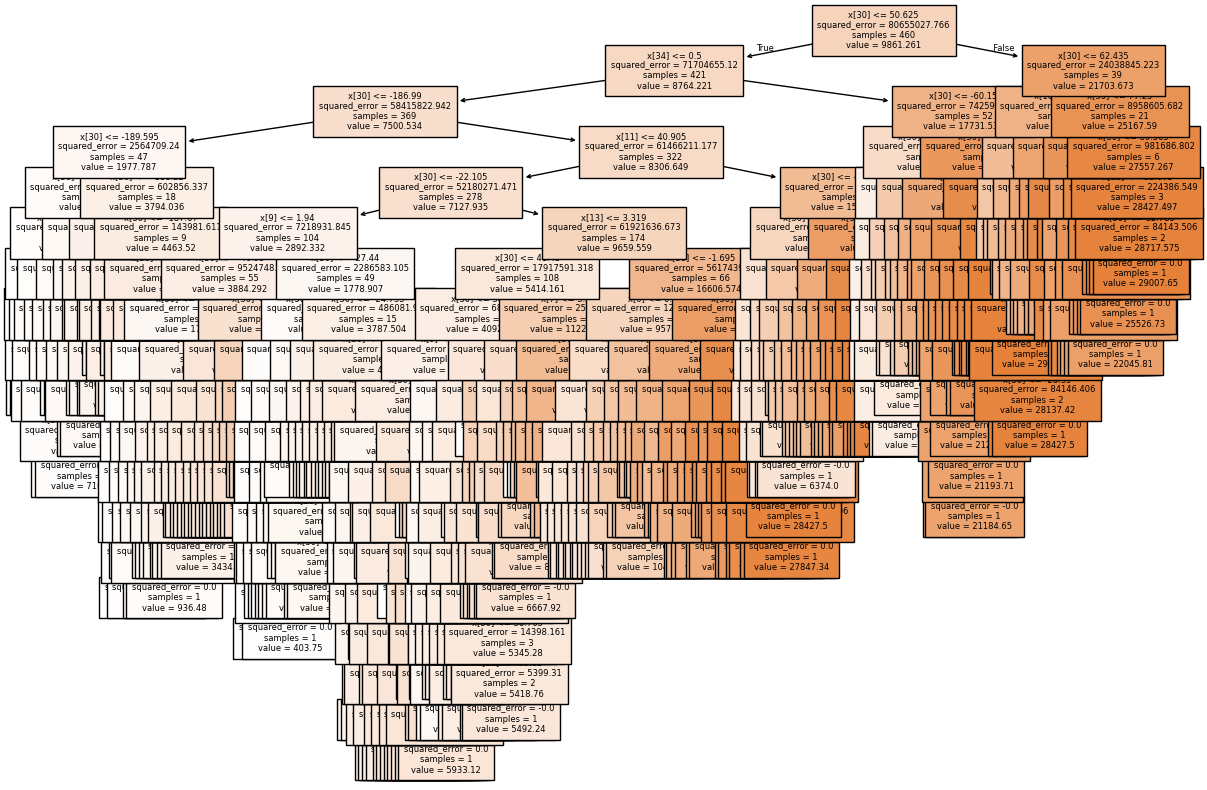

In [10]:
plt.figure(figsize=(14, 10))
plot_tree(pipe.named_steps["model"], filled=True, fontsize=6)
plt.show()


In [31]:
# ==== 0) مدل باید در حافظه باشد ====
if "pipe" not in globals():
    raise RuntimeError("مدل 'pipe' در حافظه نیست. سلول‌های آموزش را اجرا کن یا مدل .joblib را لود کن.")

from google.colab import files
import pandas as pd
import numpy as np
import re
from IPython.display import display

# ---- تنظیمات ----
SHEET_NAME = 0      # اگر شیت اول نیست، نام/شماره شیت را عوض کن
PRINT_ROWS = 20     # چند ردیف اولِ پیش‌بینی‌ها برای نمایش
MAX_MISS_ROWS = 20  # حداکثر تعداد ردیف‌هایی که برای هر ستونِ دارای کمبود چاپ می‌کنیم

# ---- نرمال‌سازی نام ستون‌ها (case/space/half-space/nums-insensitive) ----
def normalize_name(s: str) -> str:
    s = str(s)
    s = s.replace("\u200c", "").replace("\xa0", " ")  # حذف نیم‌فاصله و nbsp
    persian = "۰۱۲۳۴۵۶۷۸۹"; arabic = "٠١٢٣٤٥٦٧٨٩"; sub = "₀₁₂₃₄₅₆₇₈₉"; sup = "⁰¹²³⁴⁵⁶⁷⁸⁹"
    trans = {}
    for i,ch in enumerate(persian): trans[ord(ch)] = ord('0')+i
    for i,ch in enumerate(arabic):  trans[ord(ch)] = ord('0')+i
    for i,ch in enumerate(sub):     trans[ord(ch)] = ord('0')+i
    for i,ch in enumerate(sup):     trans[ord(ch)] = ord('0')+i
    s = s.translate(trans)
    s = s.lower()
    s = re.sub(r"\s+", "", s)        # حذف همه فاصله‌ها
    s = re.sub(r"[^a-z0-9]+", "", s) # فقط a-z0-9
    return s

# ==== 1) آپلود فایل جدید ====
print("فایل اکسل جدید (A..AF) را انتخاب کن…")
up = files.upload()
NEW_EXCEL = list(up.keys())[0]

# ==== 2) خواندن فایل و پاکسازی مقادیر خالی (رشته‌های سفید → NaN) ====
df_new = pd.read_excel(NEW_EXCEL, sheet_name=SHEET_NAME)
df_new = df_new.replace(r"^\s*$", np.nan, regex=True)

# ==== 3) ستون‌های ورودی مورد انتظار از Pipeline ====
prep = pipe.named_steps["prep"]  # ColumnTransformer
num_cols, cat_cols = [], []
for name, trans, cols in prep.transformers_:
    if name == "num":
        num_cols = [str(c) for c in cols]
    elif name == "cat":
        cat_cols = [str(c) for c in cols]
expected_cols = num_cols + cat_cols

# ==== 4) نگاشت مقاوم: expected -> ستون واقعی فایل (با نرمال‌سازی) ====
new_norm_to_real = {}
for c in df_new.columns:
    key = normalize_name(c)
    if key not in new_norm_to_real:   # اولین نگاشت را نگه می‌داریم
        new_norm_to_real[key] = c

matched_real_cols = {}   # exp -> real
missing_exp_cols = []    # exp هایی که اصلاً در فایل نبودند (بعد از نرمال‌سازی)
used_real_cols = set()

for exp in expected_cols:
    key = normalize_name(exp)
    real = new_norm_to_real.get(key)
    if real is None:
        matched_real_cols[exp] = None
        missing_exp_cols.append(exp)
    else:
        matched_real_cols[exp] = real
        used_real_cols.add(real)

ignored_input_cols = [c for c in df_new.columns if c not in used_real_cols]

# ==== 5) ساخت X_new دقیقاً با ترتیب expected_cols ====
X_new = pd.DataFrame(index=df_new.index)
# برای تشخیص «رشته غیرعددی» قبل از تبدیل، یک کپی نگه می‌داریم
X_before_numeric = pd.DataFrame(index=df_new.index)

for exp in expected_cols:
    real = matched_real_cols[exp]
    if real is None:
        X_new[exp] = np.nan
        X_before_numeric[exp] = np.nan
    else:
        X_new[exp] = df_new[real]
        X_before_numeric[exp] = df_new[real]

# تبدیل نوع برای ویژگی‌های عددی (رشته‌های غیرعددی → NaN)
non_numeric_details = {}  # exp -> list of (excel_row, original_value)
for c in num_cols:
    before = X_before_numeric[c]
    X_new[c] = pd.to_numeric(X_new[c], errors="coerce")
    bad_mask = before.notna() & X_new[c].isna()
    if bad_mask.any():
        rows = before[bad_mask].index.tolist()
        # شماره ردیف اکسل = index + 2 (چون ردیف 1 هدر است)
        non_numeric_details[c] = [(r+2, str(before.loc[r])) for r in rows[:MAX_MISS_ROWS]]

# ==== 6) گزارش نگاشت ستون‌ها ====
mapping_rows = []
for exp in expected_cols:
    real = matched_real_cols[exp]
    status = "matched" if real is not None else "missing→NaN"
    dtype_ = (str(df_new[real].dtype) if real is not None else "—")
    mapping_rows.append([exp, real if real is not None else "—", status, dtype_])
mapping_report = pd.DataFrame(mapping_rows, columns=["expected_col", "matched_input_col", "status", "dtype"])

print("\nگزارش نگاشت ستون‌ها (چند ردیف اول):")
display(mapping_report.head(30))

if missing_exp_cols:
    print("\n⚠️ ستون‌هایی که اصلاً در فایل نبودند و با NaN پر شدند:")
    print(missing_exp_cols)
if ignored_input_cols:
    print("\nℹ️ ستون‌های اضافی در فایل ورودی (مدل استفاده نمی‌کند):")
    print(ignored_input_cols)

# ==== 7) گزارش مقادیر داده‌نشده (NaN) در هر ستون و ردیف ====
# 7-الف) گزارش به‌ازای هر ستون: در چه ردیف‌هایی مقدار ندادی؟
print("\nگزارش کمبود مقادیر (NaN) به‌ازای هر ستون (شماره ردیف‌ها به سبک اکسل):")
any_missing = False
for exp in expected_cols:
    miss_mask = X_new[exp].isna()
    if miss_mask.any():
        any_missing = True
        rows = (miss_mask[miss_mask].index + 2).tolist()  # Excel row numbers
        print(f" - ستون «{exp}»: ردیف‌های {rows[:MAX_MISS_ROWS]}{' ...' if len(rows) > MAX_MISS_ROWS else ''}")
if not any_missing:
    print("هیچ مقدار خالی (NaN) پیدا نشد.")

# 7-ب) اگر در ستون‌های عددی، مقدار غیرعددی وارد شده بود (بعد از تبدیل → NaN)
if non_numeric_details:
    print("\n⚠️ مقادیر غیرعددی در ستون‌های عددی (بعد از تبدیل به عدد، NaN شدند):")
    for exp, items in non_numeric_details.items():
        sample = ", ".join([f"ردیف {r}: «{val}»" for r,val in items])
        print(f" - {exp} → {sample}{' ...' if len(items) == MAX_MISS_ROWS else ''}")

print(f"\nRows: {X_new.shape[0]}  |  Expected features: {len(expected_cols)}")

# ==== 8) پیش‌بینی ====
y_new_pred = pipe.predict(X_new)

# اگر طبقه‌بندی باشد و predict_proba داشته باشد → confidence
proba_top = None
try:
    proba = pipe.predict_proba(X_new)
    proba_top = np.max(proba, axis=1)
except Exception:
    pass

# ==== 9) خروجی و چاپ نتایج ====
out_new = df_new.copy()
out_new["AG_pred"] = y_new_pred
if proba_top is not None:
    out_new["AG_pred_confidence"] = proba_top

print("\nچند ردیف اولِ پیش‌بینی‌ها:")
cols_to_show = ["AG_pred"] + (["AG_pred_confidence"] if "AG_pred_confidence" in out_new.columns else [])
display(out_new[cols_to_show].head(PRINT_ROWS))

# اگر فقط یک ردیف داری، «عدد نهایی» را صریح چاپ می‌کنیم:
if len(out_new) == 1:
    if "AG_pred_confidence" in out_new.columns:
        print(f"\nنتیجه نهایی: AG_pred = {float(out_new['AG_pred'].iloc[0])}  |  confidence = {float(out_new['AG_pred_confidence'].iloc[0])}")
    else:
        print(f"\nنتیجه نهایی: AG_pred = {float(out_new['AG_pred'].iloc[0])}")

# ==== 10) ذخیره و دانلود فایل خروجی ====
out_path = "predictions_new.xlsx"
out_new.to_excel(out_path, index=False)
print("\nDone →", out_path)
files.download(out_path)


فایل اکسل جدید (A..AF) را انتخاب کن…


Saving EMTAHAN.xlsx to EMTAHAN (18).xlsx

گزارش نگاشت ستون‌ها (چند ردیف اول):


,expected_col,matched_input_col,status,dtype
0,H2S,H2S,matched,int64
1,N2,N2,matched,float64
2,CO2,CO2,matched,int64
3,C1,C1,matched,float64
4,C2,C2,matched,float64
5,C3,C3,matched,float64
6,iC4,iC4,matched,float64
7,nC4,nC4,matched,float64
8,iC5,iC5,matched,float64
9,nC5,nC5,matched,float64



گزارش کمبود مقادیر (NaN) به‌ازای هر ستون (شماره ردیف‌ها به سبک اکسل):
هیچ مقدار خالی (NaN) پیدا نشد.

Rows: 1  |  Expected features: 32

چند ردیف اولِ پیش‌بینی‌ها:


,AG_pred
0,29007.65



نتیجه نهایی: AG_pred = 29007.65

Done → predictions_new.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('dtype').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)